In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import ricker
from tqdm.auto import tqdm
import scipy
from time import time
import torch
import torch.fft as fft
import torch.nn.functional as F
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')

In [2]:
velocities = np.load("dataset/Density_Test.npy")
nx = 128

In [3]:
def shape_velocity(v, nx):
    v_2 = scipy.ndimage.zoom(v.reshape((51, 51)), nx/51, order=0)
    return v_2 / v_2.max()

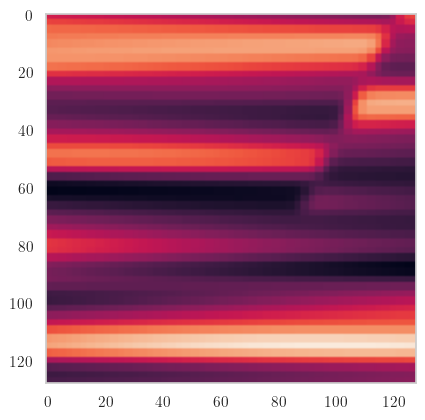

In [4]:
idx = 4
plt.imshow(shape_velocity(velocities[idx], nx))
plt.grid(False)

In [5]:
dx = 1.0

In [6]:
def init(idx, nx, device="mps"):
    nt  = 256
    isx = 1
    isz = nx // 2
    f0  = 15 * 5
    
    c = 300.0 * shape_velocity(velocities[idx], nx)
    c = torch.tensor(c, device=device, dtype=torch.float32)

    dx = 1.0
    dt = 0.001
    
    shape = (nx, nx)
    zeros = lambda: torch.zeros(shape, device=device, dtype=torch.float32)

    ap    = zeros()
    apnew = zeros()
    apold = zeros()
    ad2px = zeros()
    ad2pz = zeros()

    sp    = zeros()
    spnew = zeros()
    spold = zeros()
    sd2px = zeros()
    sd2pz = zeros()
    
    t = torch.arange(1, nt+1, device=device) * dt
    T0 = 1.0 / (15 * 5)

    tmp = torch.diff(torch.tensor(ricker(dt, T0), device=device, dtype=torch.float32)) * 1e7
    src = torch.zeros(nt, device=device, dtype=torch.float32)
    src[:tmp.numel()] = tmp

    lam = c * T0
    
    x = torch.arange(nx, device=device) * dx
    z = x.clone()

    sigma = 1.5 * dx
    x0, z0 = x[isx], z[isz]

    xx = x[:, None]
    zz = z[None, :]

    sg = torch.exp(-((xx - x0)**2 + (zz - z0)**2) / sigma**2)
    sg = sg / sg.max()

    return (nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg)

The final solution for our 2D acoustic wave problem after taking into account the finite differences time extrapolation can be written as

$$\begin{equation} p_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p){j,k} + dt^2s{j,k}^{n} + 2p_{j,k}^{n} - p_{j,k}^{n-1} \end{equation}$$

In order to compare the above numerical solution, we implement a 5-point finite difference operator to compute spatial derivatives

$$\begin{equation} \partial_t^2 p(x,t) = \frac{-p(x,t+2\mathrm{d}t) + 16p(x,t+\mathrm{d}t) - 30p(x,t) + 16p(x,t-\mathrm{d}t) - p(x,t-2\mathrm{d}t)}{12\mathrm{d}t^2} \end{equation}$$

temporal derivative is done with a 3-point finite difference operator.

In [7]:
kx = 2 * torch.pi * torch.fft.fftfreq(nx, d=dx, device="mps")
kx2 = -(kx**2).reshape(-1, 1)
kz2 = -(kx**2).reshape(1, -1)

@torch.compile
def spectral_step(sp, spold, c, dt, sg, src, it):
    sp_fft = fft.fft2(sp)
    return sp, 2*sp - spold + c**2 * dt**2 * (fft.ifft2(sp_fft * kx2).real + fft.ifft2(sp_fft * kz2).real) + sg * src[it] * dt**2
    
@torch.compile
def fd_step(ap, apold, c, dt, dx, sg, src, it):
    return ap, 2*ap - apold + c**2 * dt**2 * (
            ((-torch.roll(ap, -2, dims=0) + 16 * torch.roll(ap, -1, dims=0) - 30 * ap + 16 * torch.roll(ap,  1, dims=0) - torch.roll(ap,  2, dims=0)) / (12 * dx**2))
            + (( - torch.roll(ap, -2, dims=1) + 16 * torch.roll(ap, -1, dims=1) - 30 * ap + 16 * torch.roll(ap,  1, dims=1) - torch.roll(ap,  2, dims=1)) / (12 * dx**2))
        ) + sg * src[it] * dt**2

In [8]:
import torch.nn.functional as F

def laplacian_2d(u, dx=1.0):
    kernel = torch.tensor(
        [[[
            [0.,    0.,   -1.,    0.,    0.],
            [0.,   16.,    0.,   16.,    0.],
            [-1.,   0.,  -60.,    0.,   -1.],
            [0.,   16.,    0.,   16.,    0.],
            [0.,    0.,   -1.,    0.,    0.],
        ]]],
        device=u.device, dtype=u.dtype
    )

    x = u.unsqueeze(1)    
    x_padded = F.pad(x, pad=(2, 2, 2, 2), mode='circular')
    lap = F.conv2d(x_padded, kernel, padding=0) / (12.0 * dx**2)

    return lap.squeeze(1)

def loss_fn(u_prev, u_curr, u_pred, c, dt, dx):
    u_tt = (u_pred - 2.0 * u_curr + u_prev) / (dt ** 2)
    lap_u = laplacian_2d(u_curr, dx=dx)
    c2 = c ** 2
    R = u_tt - c2 * lap_u
    loss = (R ** 2).mean()
    return loss**0.5

In [9]:
(nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg) = init(0, nx, device='cpu')

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

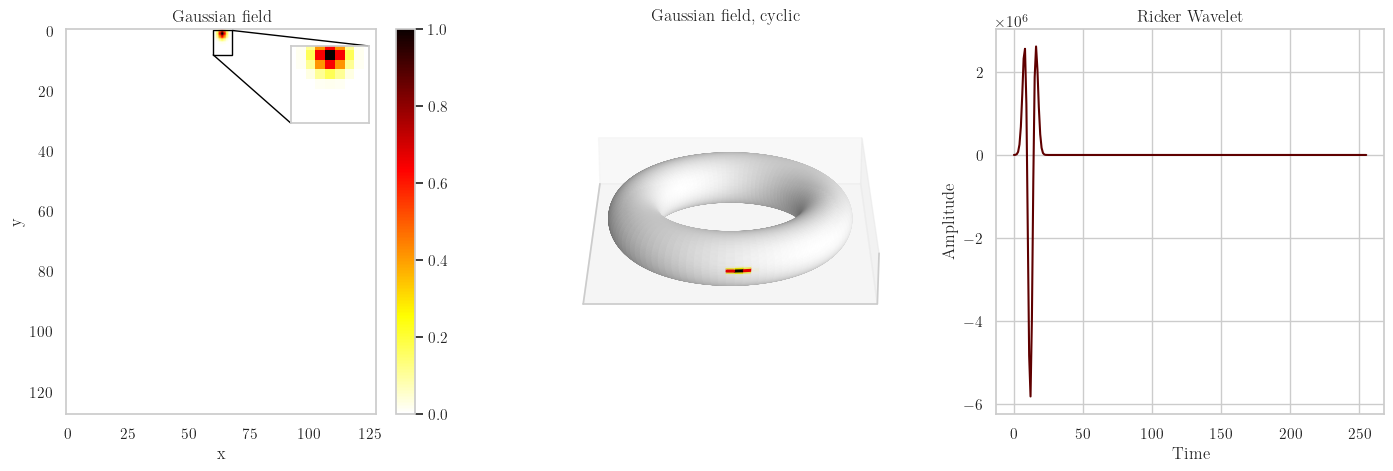

In [11]:
# Source - https://stackoverflow.com/a/77212452
# Posted by Davide_sd, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-18, License - CC BY-SA 4.0
from matplotlib.colors import Normalize
import matplotlib

theta_dim, phi_dim = sg.shape
a = sg

# Generating Torus Mesh
angle = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(angle, angle)
r, R = .2, .75
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta)
Z = r * np.sin(phi)

# compute the indexes
t, p = [var / (2 * np.pi) for var in [theta, phi]]
t = np.floor((t - 0.5) * a.shape[0]).astype(int) + 1
p = np.floor((p - 0.5) * a.shape[1]).astype(int) + 1
# extract the color value from the matrix
colors = a[t, p]
# apply a colormap to the normalized color values
norm = Normalize(vmin=colors.min(), vmax=colors.max())
cmap = matplotlib.colormaps.get_cmap("hot_r")
normalized_colors = cmap(norm(colors))

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
f = ax[0].imshow(sg, aspect='auto', cmap='hot_r')
ax[0].grid(False)
plt.colorbar(f)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Gaussian field")
axins = zoomed_inset_axes(ax[0], 4, loc=1)
axins.imshow(sg, cmap='hot_r')
axins.set_xlim(60, 68)
axins.set_ylim(8, 0)
axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])
patch, pp1,pp2 = mark_inset(ax[0], axins, loc1=1, loc2=3, fc="none", ec="0")
pp1.loc1, pp1.loc2 = 1, 4
pp2.loc1, pp2.loc2 = 3, 2 

ax[1].remove()
ax[1] = fig.add_subplot(projection = '3d')
ax[1].plot_surface(X, Y, Z, rstride = 1, cstride = 1, facecolors=normalized_colors)
ax[1].set_aspect("equal")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_zticks([])
ax[1].view_init(25, 180, 0)
ax[1].set_title("Gaussian field, cyclic")

ax[2].plot(src)
ax[2].grid('on')
ax[2].set_title("Ricker Wavelet")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Amplitude")

plt.savefig('ricker_example.jpg', dpi=250)
plt.show()

In [12]:
def evaluate_simulation(idx, nx, device="mps"):
    (nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg) = init(idx, nx, device=device)
    torch.mps.empty_cache()
    sp_loss = 0
    for it in range(nt):
        spold, sp, spnew = sp, *spectral_step(spnew, sp, c, dt, sg, src, it)
        sp_loss += (loss_fn(spold.unsqueeze(0), sp.unsqueeze(0), spnew.unsqueeze(0), c.unsqueeze(0), dt, dx)).item()*1/nt
    torch.mps.empty_cache()
    ap_loss = 0
    for it in range(nt):
        apold, ap, apnew = ap, *fd_step(apnew, ap, c, dt, dx, sg, src, it)
        ap_loss += (loss_fn(apold.unsqueeze(0), ap.unsqueeze(0), apnew.unsqueeze(0), c.unsqueeze(0), dt, dx)).item()*1/nt
    return sp_loss, ap_loss
    
evaluate_simulation(0, nx)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_inductor/lowering.py:1988: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


(23198.966855481267, 24315.395110473037)

In [13]:
def get_traces(idx, nx, device="mps"):
    (nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg) = init(idx, nx, device=device)

    trace_spectral = []
    trace_fd = []
    
    torch.mps.empty_cache()
    t0 = time()
    for it in range(nt):
        spold, sp = spectral_step(sp, spold, c, dt, sg, src, it)
        trace_spectral.append(sp[0].detach().cpu())
    time_s = time() - t0
    
    torch.mps.empty_cache()
    t0 = time()

    for it in range(nt):
        apold, ap = fd_step(ap, apold, c, dt, dx, sg, src, it)
        trace_fd.append(ap[0].detach().cpu())

    time_fd = time() - t0

    return (
        torch.stack(trace_spectral),
        time_s,
        torch.stack(trace_fd),
        time_fd,
        nt, dt, c.cpu(), nx, dx
    )

In [14]:
t_s_total, t_fd_total = [], []
for i in tqdm(range(500)):
    _, t_s, _, t_fd, _, _, _,  _, _ = get_traces(0, nx)
    t_s_total.append(t_s)
    t_fd_total.append(t_fd)

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
import seaborn as sns
import pandas as pd

In [16]:
df = pd.DataFrame({'Pseudo-Spectral': np.array(t_s_total), "Finite-Differences": np.array(t_fd_total)})

In [17]:
df.to_csv("article/simulation_times.csv")

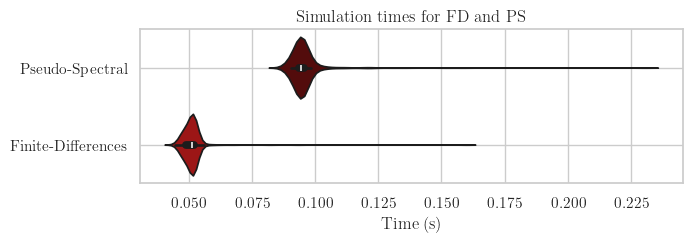

In [25]:
plt.figure(figsize=(7, 2))
sns.violinplot(df, orient='h')
plt.grid()
plt.title("Simulation times for FD and PS")
plt.xlabel("Time (s)")
plt.grid(True)
plt.savefig("simulation_times.jpg")

In [76]:
def display_traces(idx, nx):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    f = ax[0].imshow(c, cmap="hot")
    plt.colorbar(f)
    ax[0].set_title("Velocity field")
    f = ax[1].imshow(trace_fd, aspect='auto', cmap='seismic')
    ax[1].set_title(f"Finite differences, {time_fd:.3f}s, mean abs: {torch.mean(torch.abs(trace_fd)):.4e}")
    plt.colorbar(f)
    f = ax[2].imshow(trace_spectral, aspect='auto', cmap='seismic')
    ax[2].set_title(f"Pseudospectral, {time_s:.3f}s, mean abs: {torch.mean(torch.abs(trace_spectral)):.4e}")
    plt.colorbar(f)
    f = ax[3].imshow(np.abs(trace_fd-trace_spectral), aspect='auto', cmap='seismic')
    ax[3].set_title(f"Absolute difference, mean abs: {torch.mean(torch.abs(trace_fd-trace_spectral)):.4e}")
    plt.colorbar(f)
    plt.suptitle(f"Example of propagation, index: {idx}, t: {nt*dt:.3f}s, dt: {dt:.3f}s, dx: {dx:.3f}m")
    ax[0].grid(False); ax[1].grid(False); ax[2].grid(False); ax[3].grid(False)
    plt.tight_layout()
    plt.show()

/var/folders/g7/l9_hhr256md6lt7yldvmnjjw0000gn/T/ipykernel_77372/3807826273.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = ax[3].imshow(np.abs(trace_fd-trace_spectral), aspect='auto', cmap='seismic')


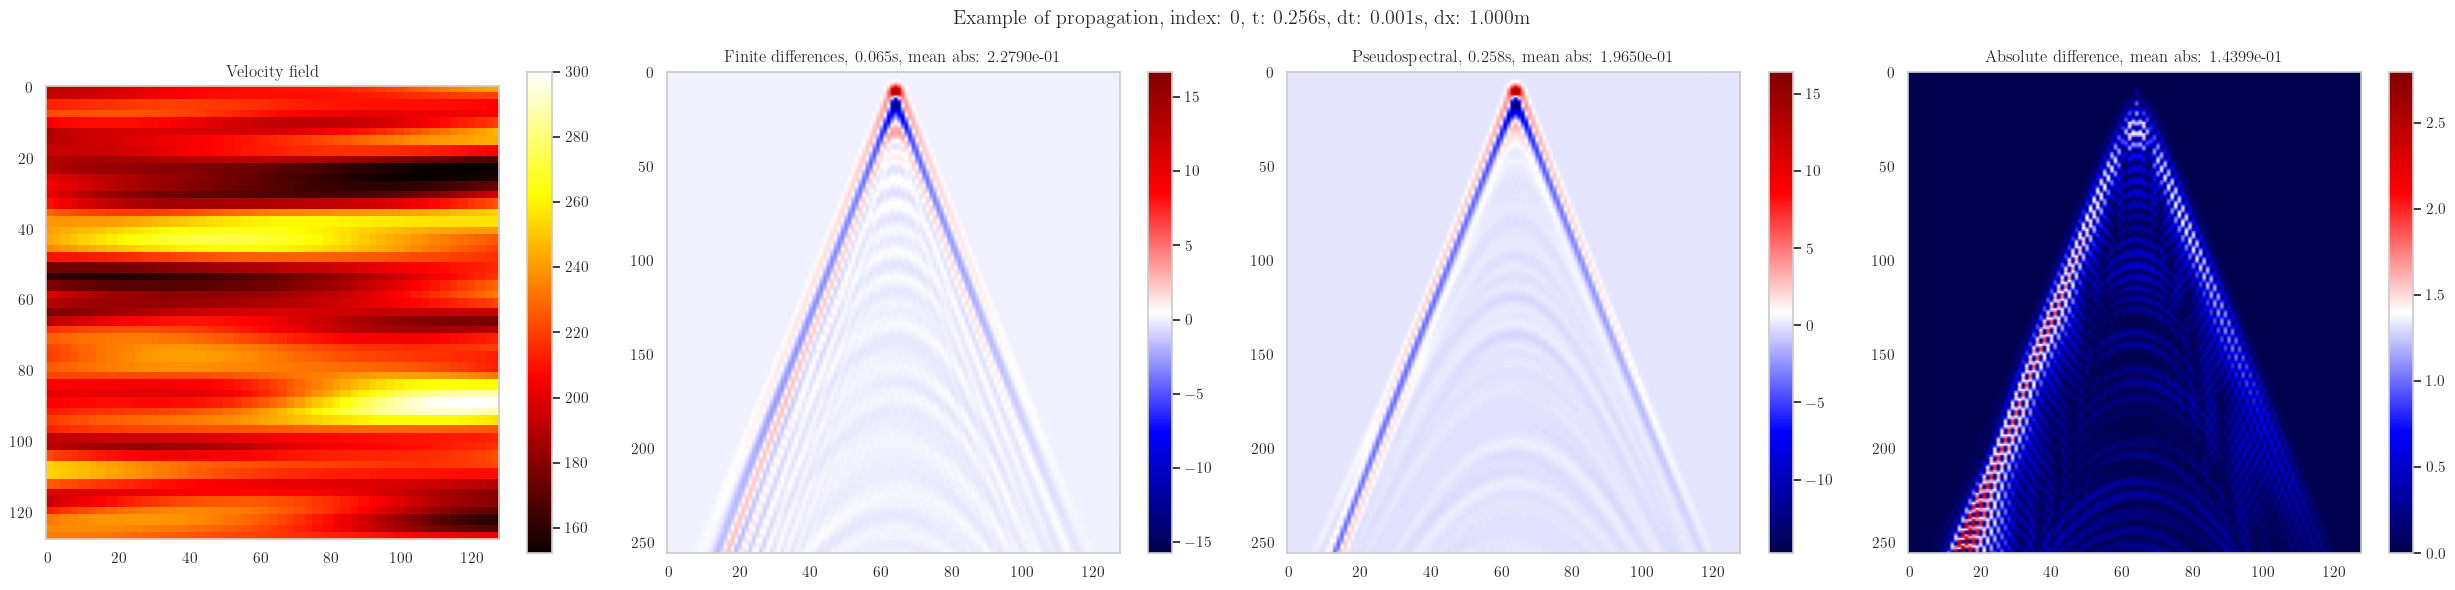

/var/folders/g7/l9_hhr256md6lt7yldvmnjjw0000gn/T/ipykernel_77372/3807826273.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = ax[3].imshow(np.abs(trace_fd-trace_spectral), aspect='auto', cmap='seismic')


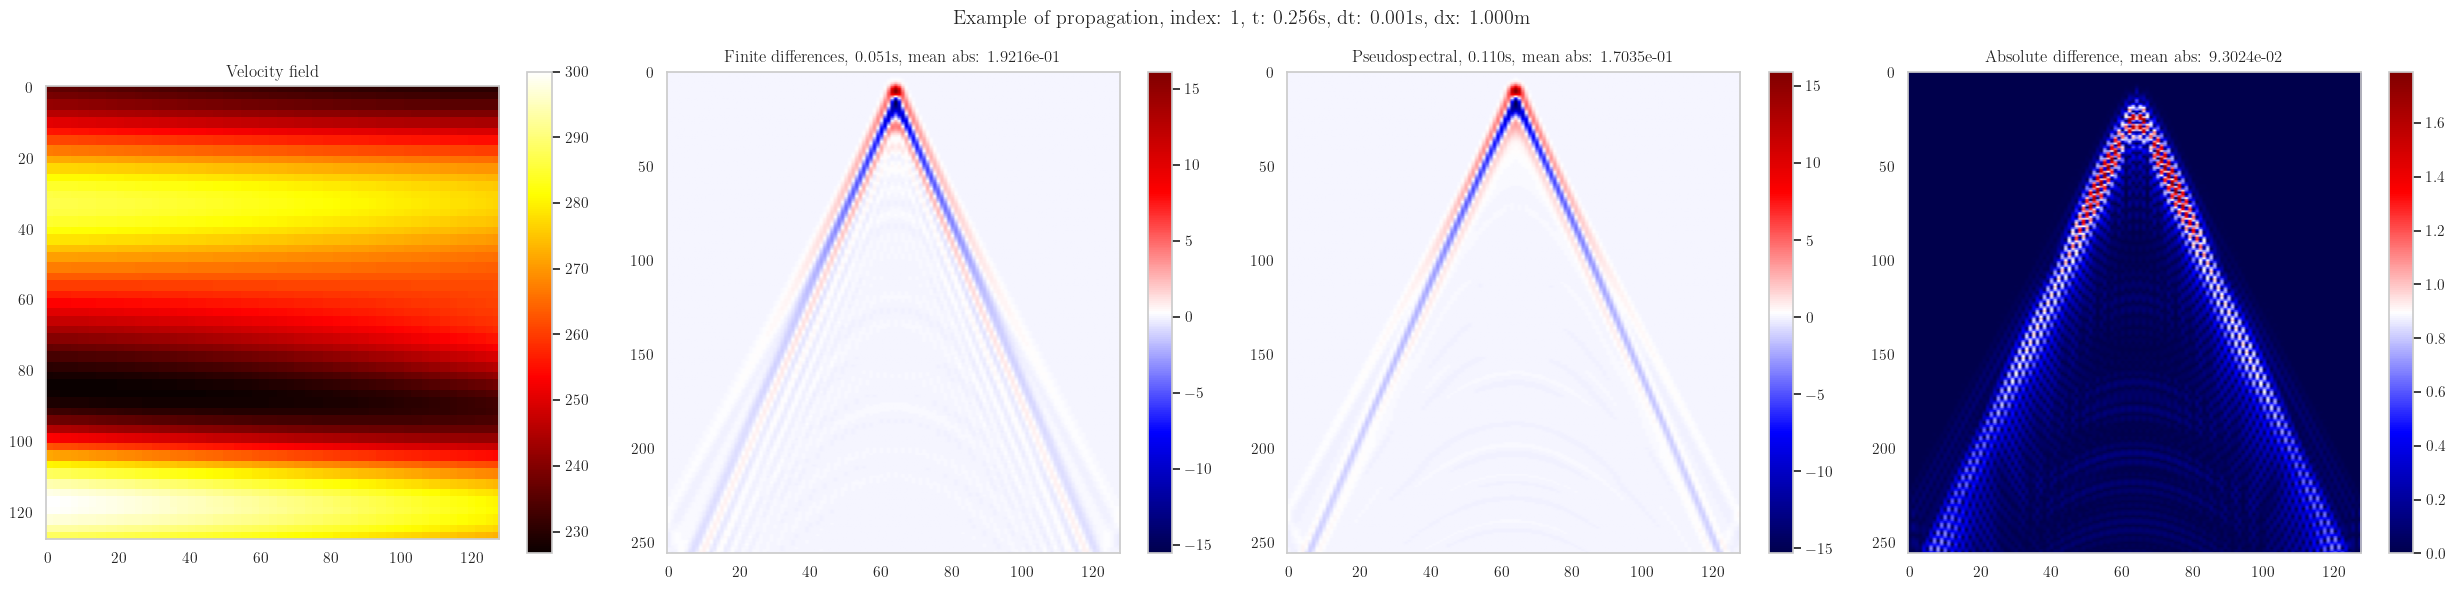

/var/folders/g7/l9_hhr256md6lt7yldvmnjjw0000gn/T/ipykernel_77372/3807826273.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = ax[3].imshow(np.abs(trace_fd-trace_spectral), aspect='auto', cmap='seismic')


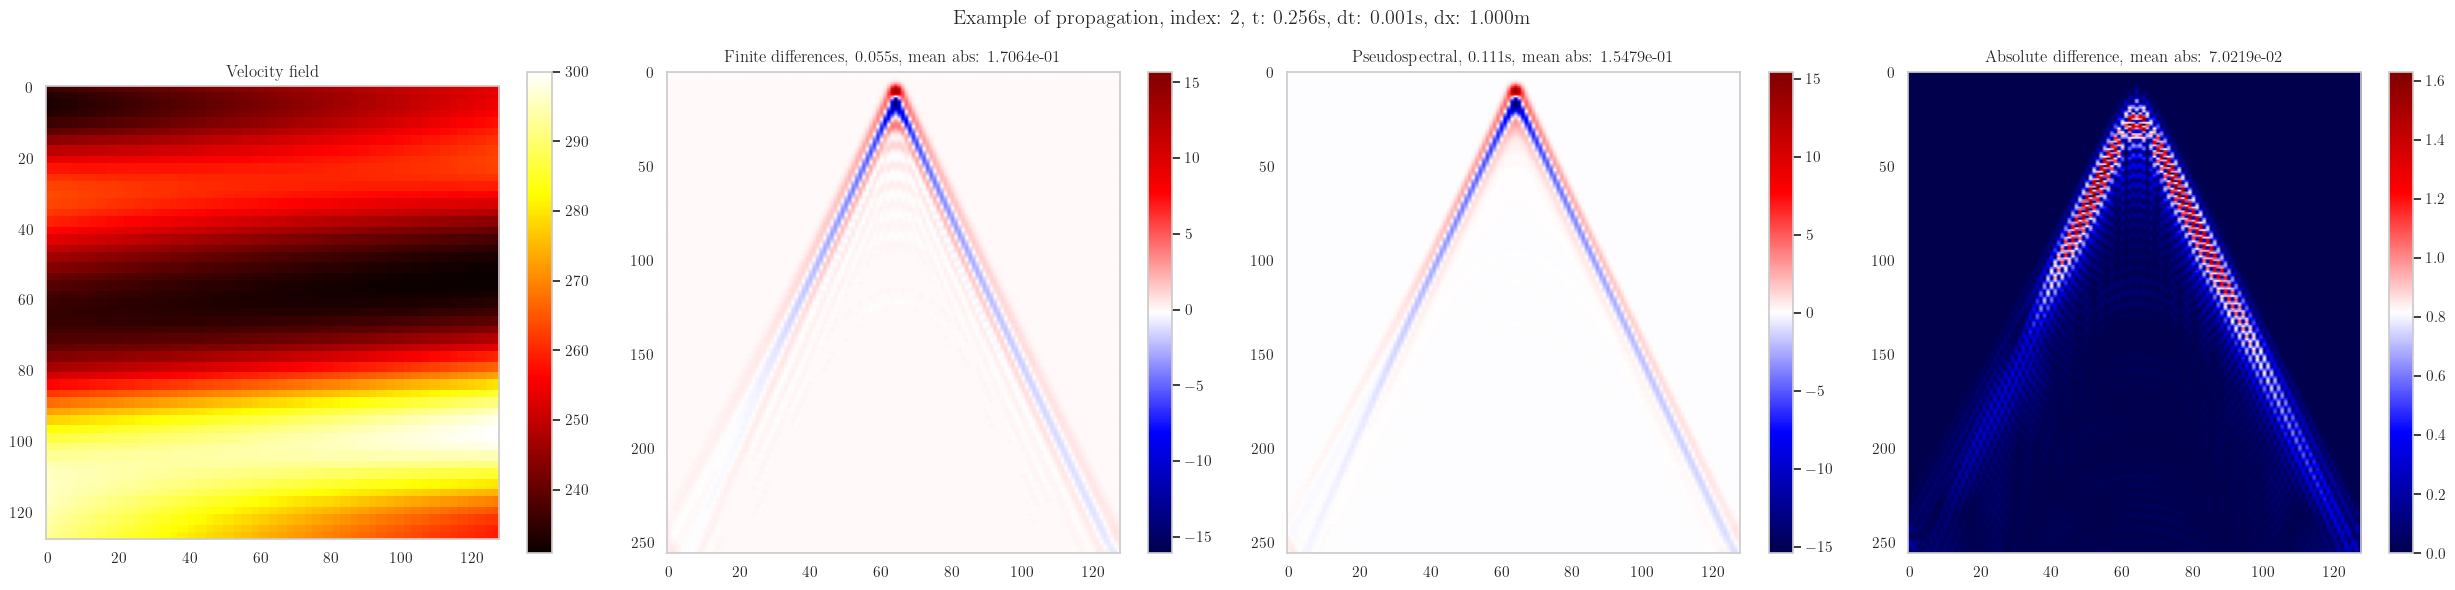

In [77]:
for idx in range(3):
    display_traces(idx, 128)

In [180]:
velocities = np.load("dataset/Density_Test.npy")
nx = 128

In [181]:
y, x = [], []
time_s_total = 0
time_fd_total = 0
cs = []
for idx in tqdm(range(velocities.shape[0])):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    y.append(trace_spectral.clone())
    x.append(trace_fd.clone())
    time_s_total += time_s
    time_fd_total += time_fd
    cs.append(c.clone())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [182]:
torch.save(torch.stack(y), "dataset/y_test.pt")
torch.save(torch.stack(x), "dataset/x_test.pt")
torch.save(torch.stack(cs), "dataset/c_test.pt")
print("Pseudospectral time, average:", time_s_total/velocities.shape[0])
print("Finite Differences time, average:", time_fd_total/velocities.shape[0])

Pseudospectral time, average: 0.09657825565338135
Finite Differences time, average: 0.05183129954338074


In [184]:
velocities = np.load("dataset/Density_Train.npy")
nx = 128

In [185]:
velocities.shape

(27000, 2601)

In [ ]:
y, x = [], []
time_s_total = 0
time_fd_total = 0
cs = []
for idx in tqdm(range(10000)):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    y.append(trace_spectral.clone())
    x.append(trace_fd.clone())
    time_s_total += time_s
    time_fd_total += time_fd
    cs.append(c.clone())

In [ ]:
torch.save(torch.stack(y), "dataset/y_train.pt")
torch.save(torch.stack(x), "dataset/x_train.pt")
torch.save(torch.stack(cs), "dataset/c_train.pt")
print("Pseudospectral time, average:", time_s_total/velocities.shape[0])
print("Finite Differences time, average:", time_fd_total/velocities.shape[0])

In [200]:
y, x = [], []
time_s_total = 0
time_fd_total = 0
cs = []
for idx in tqdm(range(10000, velocities.shape[0])):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    y.append(trace_spectral.clone())
    x.append(trace_fd.clone())
    time_s_total += time_s
    time_fd_total += time_fd
    cs.append(c.clone())

  0%|          | 0/17000 [00:00<?, ?it/s]

In [201]:
torch.save(torch.stack(y), "dataset/y_train_2.pt")
torch.save(torch.stack(x), "dataset/x_train_2.pt")
torch.save(torch.stack(cs), "dataset/c_train_2.pt")
print("Pseudospectral time, average:", time_s_total/velocities.shape[0])
print("Finite Differences time, average:", time_fd_total/velocities.shape[0])

Pseudospectral time, average: 0.07027947584788005
Finite Differences time, average: 0.03509579300880432
